In [106]:
import json
import math
from itertools import combinations
from collections import defaultdict
from typing import Dict, List, Tuple, Any, Optional
import pandas as pd


In [107]:
vqa_result_path1 = "/root/cs454_ct_diffusion_bias/results/scores_4wise_others.json"
vqa_result_path2 = "/root/cs454_ct_diffusion_bias/results/scores_4wise.json"

In [108]:
ALLOWED_VALUES = {
    "appearance_body_status": {
        "Fat",
        "Thin",
    },
    "disability_status": {
        "who uses a wheelchair",
        "without a disability",
    },
}

In [109]:
INTERSECTIONAL_AXES = [
    "race_ethnicity",
    "appearance_body_status",
    "location",
    "age",
    "gender",
    "disability_status",
]


In [110]:
S_SIZES = (1, 2, 3)  # |S| = 0, 1, 2, 3 (t = |S| + 1 = 1, 2, 3, 4), |S|=0 is baseline

In [111]:
PROB_KEY = "yes_probability"

In [112]:
def load_json_list(path: str) -> List[dict]:
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    if not isinstance(data, list):
        raise ValueError(f"Expected list at top-level in {path}, got {type(data)}")
    return data


def load_records(paths: List[str]) -> List[dict]:
    records = []
    for p in paths:
        records.extend(load_json_list(p))
    return records


In [113]:
def get_assigned(r: dict, axis: str) -> Optional[str]:
    aa = r.get("assigned_attributes", None)
    if not isinstance(aa, dict):
        return None
    v = aa.get(axis, None)
    return v


def get_vqa_entry(r: dict, axis: str) -> Optional[dict]:
    vr = r.get("vqa_results", None)
    if not isinstance(vr, dict):
        return None
    e = vr.get(axis, None)
    return e if isinstance(e, dict) else None


def get_yes_prob(r: dict, target_axis: str) -> Optional[float]:
    e = get_vqa_entry(r, target_axis)
    if e is None:
        return None
    p = e.get(PROB_KEY, None)
    if p is None:
        return None
    try:
        return float(p)
    except Exception:
        return None


def get_is_correct(r: dict, target_axis: str) -> Optional[bool]:
    e = get_vqa_entry(r, target_axis)
    if e is None:
        return None
    c = e.get("is_correct", None)
    if c is None:
        return None
    return bool(c)



In [114]:
# ----------------------------
# Metric 1: Baseline Accuracy
# ----------------------------
def baseline_accuracy(records: List[dict], target_axis: str) -> Dict[str, Any]:
    total = 0
    correct = 0
    for r in records:
        # Filter by allowed values if target_axis is in ALLOWED_VALUES
        if target_axis in ALLOWED_VALUES:
            v = get_assigned(r, target_axis)
            if v is None or v not in ALLOWED_VALUES[target_axis]:
                continue
        
        c = get_is_correct(r, target_axis)
        if c is None:
            continue
        total += 1
        if c:
            correct += 1
    acc = correct / total if total > 0 else float("nan")
    return {"acc": acc, "n": total, "correct": correct}

In [115]:
# ----------------------------
# Intersectional Metrics (|S| in {2,3,4})
# ----------------------------
def mean(xs: List[float]) -> float:
    return sum(xs) / len(xs) if xs else float("nan")


def pairwise_abs_diffs(vals: List[float]) -> float:
    """mean over unordered pairs of |v_i - v_j|"""
    if len(vals) < 2:
        return float("nan")
    s = 0.0
    cnt = 0
    for i in range(len(vals)):
        for j in range(i + 1, len(vals)):
            s += abs(vals[i] - vals[j])
            cnt += 1
    return s / cnt if cnt > 0 else float("nan")


def compute_intersectional_for_S(
    records: List[dict],
    target_axis: str,
    S: Tuple[str, ...],
    vary_axis: str,
) -> Dict[str, Any]:
    r"""
    Computes:
      - Flip_soft(A_t | A_k, S) = E_context[ mean_{pairs} |mu_i - mu_j| ]
      - Gap(A_t | A_k, S) = E_context[ max Acc - min Acc ]
    where context fixes S\{k}, and groups vary only in k.

    Returns summary + diagnostics.
    """

    # context_key -> k_value -> stats
    # stats: sum_prob, n_prob, sum_correct, n_correct
    buckets: Dict[Tuple[Tuple[str, str], ...], Dict[str, Dict[str, float]]] = defaultdict(
        lambda: defaultdict(lambda: {"sum_prob": 0.0, "n_prob": 0.0, "sum_corr": 0.0, "n_corr": 0.0})
    )

    other_axes = tuple(ax for ax in S if ax != vary_axis)

    # Fill buckets
    for r in records:
        assigned = {}
        ok = True

        for ax in S:
            v = get_assigned(r, ax)
            if v is None:
                ok = False
                break

            # Filter specific axes by allowed values
            if ax in ALLOWED_VALUES:
                if v not in ALLOWED_VALUES[ax]:
                    ok = False
                    break

            assigned[ax] = v

        if not ok:
            continue

        # Also filter target_axis if it's in ALLOWED_VALUES (even if not in S)
        if target_axis in ALLOWED_VALUES:
            v_target = get_assigned(r, target_axis)
            if v_target is None or v_target not in ALLOWED_VALUES[target_axis]:
                continue

        # need target outputs
        p = get_yes_prob(r, target_axis)
        c = get_is_correct(r, target_axis)

        # if both missing, skip
        if p is None and c is None:
            continue

        # context key: ordered tuple of (axis,value) for S\{k}
        context_key = tuple((ax, assigned[ax]) for ax in other_axes)
        # For |S| = 0, assigned is empty, so get vary_axis value directly
        if len(S) == 0:
            k_val = get_assigned(r, vary_axis)
            if k_val is None:
                continue
            # Filter vary_axis if it's in ALLOWED_VALUES
            if vary_axis in ALLOWED_VALUES:
                if k_val not in ALLOWED_VALUES[vary_axis]:
                    continue
        else:
            k_val = assigned[vary_axis]

        st = buckets[context_key][k_val]
        if p is not None:
            st["sum_prob"] += p
            st["n_prob"] += 1.0
        if c is not None:
            st["sum_corr"] += 1.0 if c else 0.0
            st["n_corr"] += 1.0

    # Compute per-context flip and gap
    flip_per_context = []
    gap_per_context = []
    used_contexts_flip = 0
    used_contexts_gap = 0
    skipped_contexts = 0

    for ctx, by_k in buckets.items():
        # Need >=2 k-values with prob stats to compute flip
        mus = []
        for kv, st in by_k.items():
            if st["n_prob"] > 0:
                mus.append(st["sum_prob"] / st["n_prob"])
        if len(mus) >= 2:
            flip_c = pairwise_abs_diffs(mus)  # soft flip in [0,1]
            if not math.isnan(flip_c):
                flip_per_context.append(flip_c)
                used_contexts_flip += 1

        # Need >=2 k-values with acc stats to compute gap
        accs = []
        for kv, st in by_k.items():
            if st["n_corr"] > 0:
                accs.append(st["sum_corr"] / st["n_corr"])
        if len(accs) >= 2:
            gap_c = max(accs) - min(accs)
            if not math.isnan(gap_c):
                gap_per_context.append(gap_c)
                used_contexts_gap += 1

        if len(mus) < 2 and len(accs) < 2:
            skipped_contexts += 1

    flip = mean(flip_per_context)
    gap = mean(gap_per_context)

    return {
        "target_axis": target_axis,
        "S": list(S),
        "vary_axis": vary_axis,
        "flip_soft": flip,             # main flip metric
        "gap": gap,                    # main gap metric
        "n_contexts_total": len(buckets),
        "n_contexts_used_flip": used_contexts_flip,
        "n_contexts_used_gap": used_contexts_gap,
        "n_contexts_skipped_both": skipped_contexts,
    }


def compute_all_intersectional_metrics(
    records: List[dict],
    intersectional_axes: List[str],
    sizes: Tuple[int, ...] = (2, 3, 4),
    target_axes: Optional[List[str]] = None,
) -> Dict[str, Any]:
    """
    For each target_axis in target_axes:
      - baseline Acc(A_t)
      - for each |S| in sizes:
         for each S subset:
            for each vary_axis in S:
              compute flip_soft and gap

    If target_axes is None, we use the same axes as intersectional_axes.
    """
    if target_axes is None:
        target_axes = list(intersectional_axes)

    out: Dict[str, Any] = {
        "baseline_accuracy": {},
        "intersectional": defaultdict(lambda: defaultdict(dict)),  # [target][|S|][S_str][vary] -> metrics
        "config": {
            "intersectional_axes": intersectional_axes,
            "sizes": list(sizes),
            "target_axes": target_axes,
            "flip_definition": r"soft = E_context[ mean_{pairs} |mu_i - mu_j| ], mu=mean(yes_probability)",
            "gap_definition": "E_context[ max Acc - min Acc ]",
        },
    }

    # Baseline accuracy
    for t in target_axes:
        out["baseline_accuracy"][t] = baseline_accuracy(records, t)

    # Intersectional metrics
    for t in target_axes:
        for m in sizes:
            if m == 0:
                # |S| = 0: baseline case, unconditional gap/flip
                # S = (), vary_axis can be any axis (except target)
                # This computes Gap(A_t | A_k) = max_{a_k} Acc_t(a_k) - min_{a_k} Acc_t(a_k)
                S = tuple()
                S_str = ""
                out["intersectional"][t][m][S_str] = {}
                # For each possible vary_axis (except target)
                for k in intersectional_axes:
                    if k == t:
                        continue  # Skip if vary_axis is same as target
                    # Compute unconditional gap/flip
                    res = compute_intersectional_for_S(records, target_axis=t, S=S, vary_axis=k)
                    out["intersectional"][t][m][S_str][k] = res
            else:
                for S in combinations(intersectional_axes, m):
                    S = tuple(S)
                    # According to the definition: target (A_t) should NOT be in S
                    # Only vary (A_k) should be in S
                    if t in S:
                        continue  # Skip if target is in S
                    S_str = "|".join(S)
                    out["intersectional"][t][m][S_str] = {}
                    for k in S:
                        # k (vary_axis) must be in S (already guaranteed by for k in S)
                        res = compute_intersectional_for_S(records, target_axis=t, S=S, vary_axis=k)
                        out["intersectional"][t][m][S_str][k] = res

    # convert defaultdict to dict for JSON
    out["intersectional"] = {t: {m: dict(v) for m, v in ms.items()} for t, ms in out["intersectional"].items()}
    return out



In [116]:
# ----------------------------
# Pretty summary (optional)
# ----------------------------
def topk_by_metric(results: Dict[str, Any], metric: str, k: int = 15) -> List[Tuple[float, str, int, str, str]]:
    """
    Returns top-k tuples:
      (metric_value, target_axis, |S|, S_str, vary_axis)
    metric in {"flip_soft", "gap"}
    """
    items = []
    for t, ms in results["intersectional"].items():
        for m_str, S_map in ms.items():
            m = int(m_str)
            for S_str, vary_map in S_map.items():
                for vary_axis, res in vary_map.items():
                    val = res.get(metric, float("nan"))
                    if val == val:  # not NaN
                        items.append((val, t, m, S_str, vary_axis))
    items.sort(reverse=True, key=lambda x: x[0])
    return items[:k]


def create_flip_table_by_S(results: Dict[str, Any], size: int) -> pd.DataFrame:
    """
    Create a table for Flip (soft) results for a specific |S| size.
    Returns DataFrame with columns: Target, S, Vary Axis, Flip (soft)
    """
    rows = []
    for t, ms in results["intersectional"].items():
        for m_str, S_map in ms.items():
            m = int(m_str)
            if m != size:
                continue
            for S_str, vary_map in S_map.items():
                for vary_axis, res in vary_map.items():
                    val = res.get("flip_soft", float("nan"))
                    if val == val:  # not NaN
                        rows.append({
                            "Target": t,
                            "S": S_str,
                            "Vary Axis": vary_axis,
                            "Flip (soft)": val
                        })
    
    df = pd.DataFrame(rows)
    if len(df) > 0:
        df = df.sort_values("Flip (soft)", ascending=False)
        df["Flip (soft)"] = df["Flip (soft)"].round(4)
    return df


if __name__ == "__main__":
    paths = [vqa_result_path1, vqa_result_path2]
    records = load_records(paths)

    # Compute metrics
    results = compute_all_intersectional_metrics(
        records=records,
        intersectional_axes=INTERSECTIONAL_AXES,
        sizes=S_SIZES,
        target_axes=None,  # default: same as INTERSECTIONAL_AXES
    )

    # Save
    out_path = "/root/cs454_ct_diffusion_bias/intersectional_metrics_summary.json"
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(results, f, ensure_ascii=False, indent=2)
    print(f"Saved: {out_path}")

    # Quick console summary
    print("\n[Baseline Accuracy]")
    for ax, d in results["baseline_accuracy"].items():
        print(f"  {ax:24s}  acc={d['acc']:.4f}  (n={d['n']})")

    # Flip (soft) tables by S size
    print("\n" + "="*80)
    print("[Flip (soft) Results by |S|]")
    print("="*80)
    
    for size in [2, 3, 4]:
        df = create_flip_table_by_S(results, size)
        if len(df) > 0:
            print(f"\n|S| = {size}")
            print("-" * 80)
            # Display with index
            pd.set_option('display.max_columns', None)
            pd.set_option('display.width', None)
            pd.set_option('display.max_colwidth', 60)
            print(df.to_string(index=True))
            print()
        else:
            print(f"\n|S| = {size}: No data available")
    
    print("\n[Top Gap entries]")
    for val, t, m, S_str, k_axis in topk_by_metric(results, "gap", k=10):
        print(f"  Gap:       {val:.4f}   target={t}   |S|={m}   S={S_str}   vary={k_axis}")

Saved: /root/cs454_ct_diffusion_bias/intersectional_metrics_summary.json

[Baseline Accuracy]
  race_ethnicity            acc=0.7848  (n=189800)
  appearance_body_status    acc=0.2162  (n=63270)
  location                  acc=0.8433  (n=189800)
  age                       acc=0.7575  (n=189800)
  gender                    acc=0.8193  (n=189800)
  disability_status         acc=0.5178  (n=54260)

[Flip (soft) Results by |S|]

|S| = 2
--------------------------------------------------------------------------------
                     Target                                         S               Vary Axis  Flip (soft)
85                   gender                        race_ethnicity|age                     age       0.2774
95                   gender                              location|age                     age       0.2773
98                   gender                     age|disability_status                     age       0.2728
91                   gender                appearance_

## Bar Chart Visualization for 2wise, 3wise, 4wise


In [160]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# 한글 폰트 설정 (필요시)
# plt.rcParams['font.family'] = 'DejaVu Sans'
rcParams['figure.figsize'] = (16, 10)
rcParams['font.size'] = 9

# Axis abbreviations mapping
AXIS_ABBREVIATIONS = {
    "gender": "GEN",
    "race_ethnicity": "ETH",
    "age": "AGE",
    "appearance_body_status": "APP",
    "location": "LOC",
    "disability_status": "DIS"
}

def abbreviate_axis(axis: str) -> str:
    """Convert axis name to abbreviation"""
    return AXIS_ABBREVIATIONS.get(axis, axis)

def abbreviate_S_str(S_str: str, vary_axis: str) -> str:
    """Convert S string (e.g., 'race_ethnicity|age') to abbreviated form (e.g., 'ETH AGE')"""
    if S_str == "":
        return "-"
    axes = S_str.split("|")
    return " ".join([abbreviate_axis(ax) for ax in axes if ax != vary_axis])  # Use space instead of | to avoid confusion with label separator

def size_to_wise(size: int) -> str:
    """Convert |S| size to wise notation: |S|=1 -> 2wise, |S|=2 -> 3wise, |S|=3 -> 4wise"""
    return f"{size + 1}wise"


In [161]:
def prepare_data_for_visualization(results: Dict[str, Any], sizes: Tuple[int, ...] = (1, 2, 3)) -> Dict[str, Dict[str, List[Dict[str, Any]]]]:
    """
    Prepare data for visualization.
    Returns: {metric: {size: [data_points]}}
    where data_points contain: value, target, S_str, vary_axis, label
    """
    output = {
        "flip_soft": {size: [] for size in sizes},
        "gap": {size: [] for size in sizes}
    }
    
    for t, ms in results["intersectional"].items():
        for m_str, S_map in ms.items():
            m = int(m_str)
            if m not in sizes:
                continue
            
            for S_str, vary_map in S_map.items():
                for vary_axis, res in vary_map.items():
                    # Get metric values
                    flip_val = res.get("flip_soft", float("nan"))
                    gap_val = res.get("gap", float("nan"))
                    
                    # Create label with abbreviations: "{varying axis} | {target axis}"
                    t_abbr = abbreviate_axis(t)
                    vary_abbr = abbreviate_axis(vary_axis)
                    
                    # Always compute S_abbr for data_point (kept for reference but not used in label)
                    S_abbr = abbreviate_S_str(S_str, vary_axis)
                    
                    # Label format: {varying axis} | {target axis}
                    label = f"{S_abbr} {{ {vary_abbr} }} | {t_abbr}"
                    
                    # Add flip_soft data point
                    if not math.isnan(flip_val):
                        output["flip_soft"][m].append({
                            "value": flip_val,
                            "target": t,
                            "target_abbr": t_abbr,
                            "S_str": S_str,
                            "S_abbr": S_abbr,
                            "vary_axis": vary_axis,
                            "vary_abbr": vary_abbr,
                            "label": label
                        })
                    
                    # Add gap data point
                    if not math.isnan(gap_val):
                        output["gap"][m].append({
                            "value": gap_val,
                            "target": t,
                            "target_abbr": t_abbr,
                            "S_str": S_str,
                            "S_abbr": S_abbr,
                            "vary_axis": vary_axis,
                            "vary_abbr": vary_abbr,
                            "label": label
                        })
    
    # Sort by value (descending) for each metric and size
    for metric in ["flip_soft", "gap"]:
        for size in sizes:
            output[metric][size].sort(key=lambda x: x["value"], reverse=True)
    
    return output


In [162]:
def create_bar_charts(data: Dict[str, Dict[str, List[Dict[str, Any]]]], 
                      sizes: Tuple[int, ...] = (1, 2, 3),
                      top_k: int = 10,
                      bottom_k: int = 10):
    """
    Create bar charts for flip_soft and gap metrics across different |S| sizes.
    Shows top K and bottom K entries.
    
    Args:
        data: Output from prepare_data_for_visualization
        sizes: Sizes to visualize
        top_k: Number of top entries to show
        bottom_k: Number of bottom entries to show
    """
    metrics = ["flip_soft", "gap"]
    metric_titles = {
        "flip_soft": "Flip (soft)",
        "gap": "Gap"
    }
    
    fig, axes = plt.subplots(len(metrics), len(sizes), figsize=(18, 10))
    fig.suptitle('Intersectional Bias Metrics by Wise Size (Top & Bottom 10)\nLabel format: Fixed axes {Varying axis} | {Target axis}', 
                 fontsize=16, fontweight='bold')
    
    # Add legend explaining label format at the bottom
    legend_text = 'Label format: Fixed axes {Varying axis} | {Target axis}\n(If varying axis is in fixed axes, it appears as {Varying axis} in braces)'
    fig.text(0.5, 0.02, legend_text, ha='center', fontsize=10, style='italic')
    
    # If only one row or column, make axes 2D
    if len(metrics) == 1:
        axes = axes.reshape(1, -1)
    if len(sizes) == 1:
        axes = axes.reshape(-1, 1)
    
    for metric_idx, metric in enumerate(metrics):
        for size_idx, size in enumerate(sizes):
            ax = axes[metric_idx, size_idx]
            
            # Get data for this metric and size
            metric_data = data[metric][size]
            
            if len(metric_data) == 0:
                wise_label = size_to_wise(size)
                ax.text(0.5, 0.5, f'No data for {wise_label}', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{metric_titles[metric]}\n{wise_label}', fontsize=11)
                continue
            
            # Sort by value
            metric_data_sorted = sorted(metric_data, key=lambda x: x["value"], reverse=True)
            
            # Get top K and bottom K
            top_data = metric_data_sorted[:top_k] if len(metric_data_sorted) >= top_k else metric_data_sorted
            bottom_data = metric_data_sorted[-bottom_k:] if len(metric_data_sorted) >= bottom_k else []
            
            # Combine: top (descending) + bottom (ascending for display)
            if bottom_data:
                bottom_data_reversed = list(reversed(bottom_data))  # Reverse so lowest is at bottom
                combined_data = top_data + bottom_data_reversed
            else:
                combined_data = top_data
            
            # Extract values and labels
            values = [d["value"] for d in combined_data]
            labels = [d["label"] for d in combined_data]
            
            # Create colors: top K in one color, bottom K in another
            colors = []
            for i, d in enumerate(combined_data):
                if i < len(top_data):
                    colors.append('#2E86AB')  # Blue for top
                else:
                    colors.append('#A23B72')  # Purple/Pink for bottom
            
            # Create bar chart
            bars = ax.barh(range(len(values)), values, color=colors, alpha=0.7)
            
            # Add separator line between top and bottom if both exist
            if top_data and bottom_data:
                separator_idx = len(top_data)
                ax.axhline(y=separator_idx - 0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)
            
            # Customize axes
            ax.set_yticks(range(len(labels)))
            ax.set_yticklabels(labels, fontsize=8)
            ax.set_xlabel('Metric Value', fontsize=10)
            wise_label = size_to_wise(size)
            title = f'{metric_titles[metric]}\n{wise_label}'
            if top_data and bottom_data:
                title += f'\n(Top {len(top_data)}, Bottom {len(bottom_data)})'
            elif top_data:
                title += f'\n(Top {len(top_data)})'
            ax.set_title(title, fontsize=11)
            ax.grid(axis='x', alpha=0.3)
            
            # Invert y-axis so highest values are at top
            ax.invert_yaxis()
    
    plt.tight_layout()
    return fig


Saved figure: /root/cs454_ct_diffusion_bias/intersectional_metrics_bar_charts.png


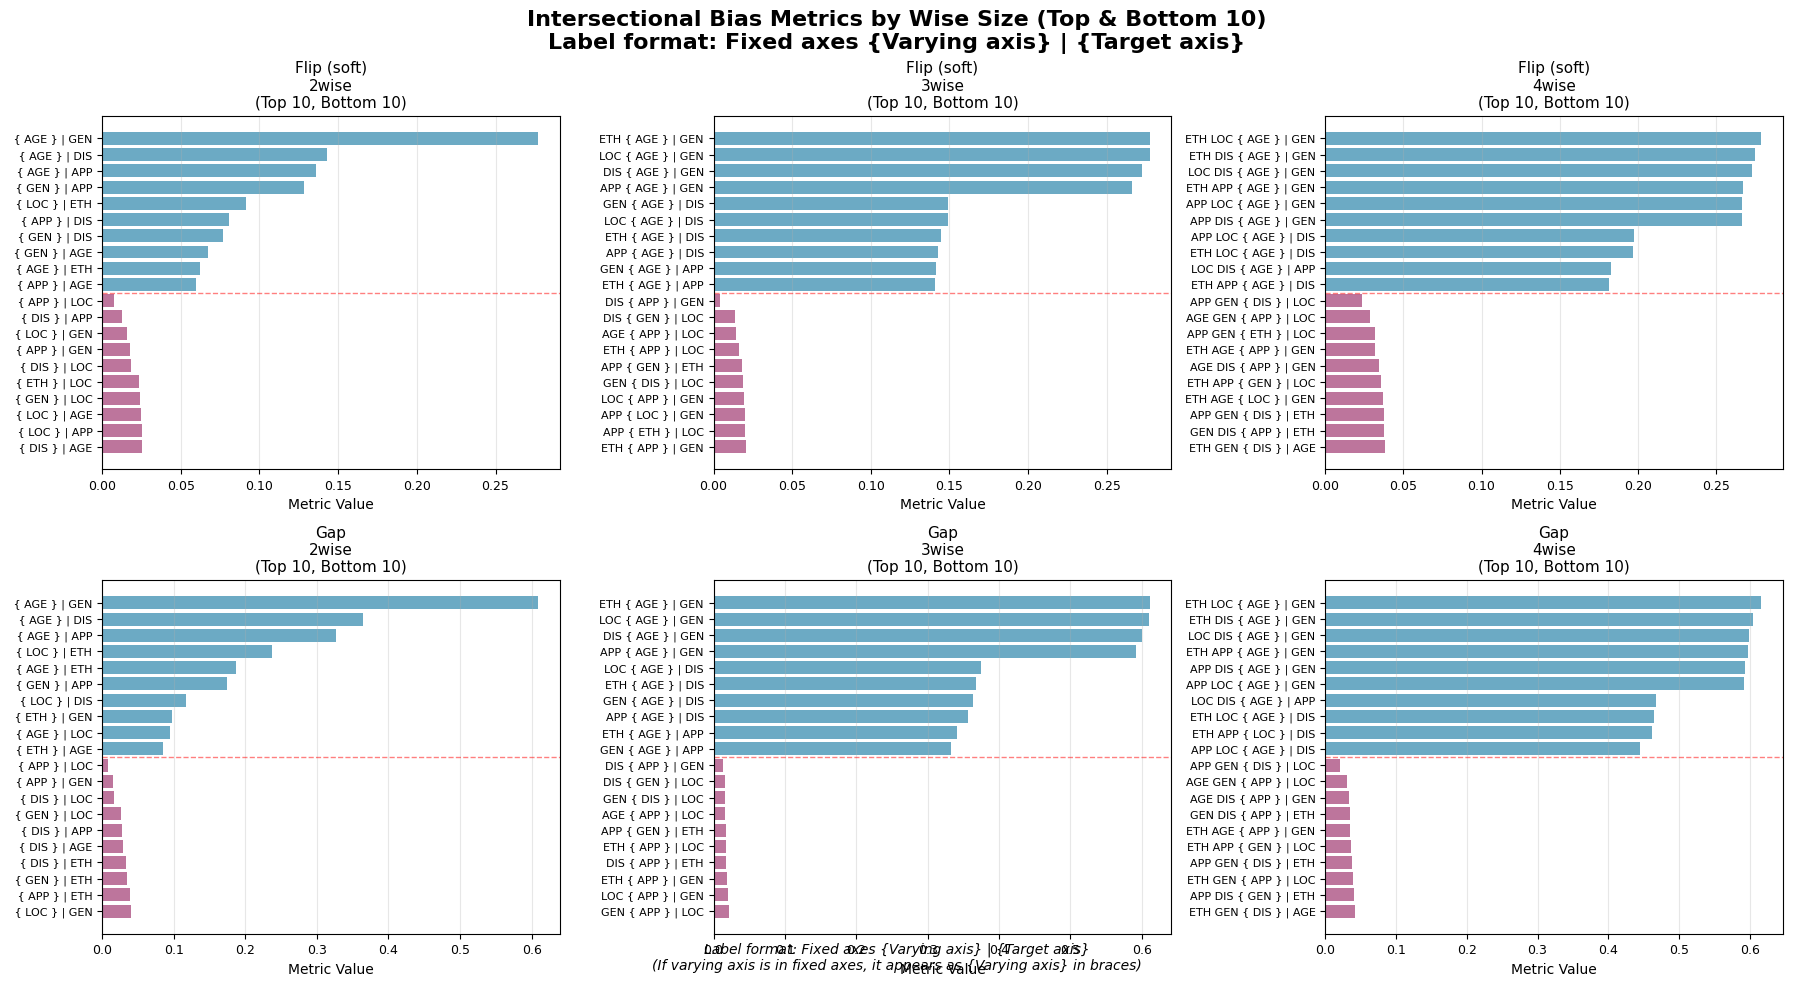

In [163]:
# Load results if not already computed
# If running this cell independently, uncomment the following:
# paths = [vqa_result_path1, vqa_result_path2]
# records = load_records(paths)
# results = compute_all_intersectional_metrics(
#     records=records,
#     intersectional_axes=INTERSECTIONAL_AXES,
#     sizes=S_SIZES,
#     target_axes=None,
# )

# Prepare data for visualization
viz_data = prepare_data_for_visualization(results, sizes=(1, 2, 3))

# Create bar charts - showing top 10 and bottom 10 entries per size
fig = create_bar_charts(viz_data, sizes=(1, 2, 3), top_k=10, bottom_k=10)

# Save figure
output_fig_path = "/root/cs454_ct_diffusion_bias/intersectional_metrics_bar_charts.png"
fig.savefig(output_fig_path, dpi=300, bbox_inches='tight')
print(f"Saved figure: {output_fig_path}")

plt.show()


## Export Full Results to CSV and JSON


In [170]:
def export_full_results_to_csv_json(results: Dict[str, Any], 
                                     sizes: Tuple[int, ...] = (1, 2, 3),
                                     output_dir: str = "/root/cs454_ct_diffusion_bias"):
    """
    Export full intersectional metrics results to CSV and JSON formats.
    
    Args:
        results: Results from compute_all_intersectional_metrics
        sizes: Sizes to export
        output_dir: Output directory for files
    """
    import os
    
    # Prepare data for export
    export_data = []
    
    for t, ms in results["intersectional"].items():
        for m_str, S_map in ms.items():
            m = int(m_str)
            if m not in sizes:
                continue
            
            for S_str, vary_map in S_map.items():
                for vary_axis, res in vary_map.items():
                    # Get metric values
                    flip_val = res.get("flip_soft", float("nan"))
                    gap_val = res.get("gap", float("nan"))
                    
                    # Create abbreviations
                    t_abbr = abbreviate_axis(t)
                    vary_abbr = abbreviate_axis(vary_axis)
                    S_abbr = abbreviate_S_str(S_str, vary_axis)
                    
                    # Create label
                    if S_str == "":
                        label = f"- | {vary_abbr} | {t_abbr}"
                    else:
                        S_axes = S_str.split("|")
                        if vary_axis in S_axes:
                            S_without_vary = [ax for ax in S_axes if ax != vary_axis]
                            if len(S_without_vary) == 0:
                                S_part = f"{{{vary_abbr}}}"
                            else:
                                S_abbr_without_vary = " ".join([abbreviate_axis(ax) for ax in S_without_vary])
                                S_part = f"{S_abbr_without_vary} {{{vary_abbr}}}"
                            label = f"{S_part} | {t_abbr}"
                        else:
                            label = f"{S_abbr} | {vary_abbr} | {t_abbr}"
                    
                    # Create wise label
                    wise_label = size_to_wise(m)
                    
                    export_data.append({
                        "wise": wise_label,
                        "|S|": m,
                        "target_axis": t,
                        "target_abbr": t_abbr,
                        "S": S_str,
                        "S_abbr": S_abbr,
                        "vary_axis": vary_axis,
                        "vary_abbr": vary_abbr,
                        "label": label,
                        "flip_soft": flip_val if not math.isnan(flip_val) else None,
                        "gap": gap_val if not math.isnan(gap_val) else None,
                        "n_contexts_total": res.get("n_contexts_total", 0),
                        "n_contexts_used_flip": res.get("n_contexts_used_flip", 0),
                        "n_contexts_used_gap": res.get("n_contexts_used_gap", 0),
                        "n_contexts_skipped_both": res.get("n_contexts_skipped_both", 0),
                    })
    
    # Create DataFrame
    df = pd.DataFrame(export_data)
    
    # Sort by wise, then by flip_soft (descending), then by gap (descending)
    df = df.sort_values(["wise", "flip_soft", "gap"], 
                        ascending=[True, False, False], 
                        na_position='last')
    
    # Save to CSV
    csv_path = os.path.join(output_dir, "intersectional_metrics_full_results.csv")
    df.to_csv(csv_path, index=False, encoding='utf-8')
    print(f"Saved CSV: {csv_path}")
    print(f"  Total rows: {len(df)}")
    
    # Save to JSON
    json_path = os.path.join(output_dir, "intersectional_metrics_full_results.json")
    json_data = {
        "metadata": {
            "export_date": pd.Timestamp.now().isoformat(),
            "sizes": list(sizes),
            "total_rows": len(df),
            "description": "Full intersectional bias metrics results for all combinations"
        },
        "data": df.to_dict('records')
    }
    
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(json_data, f, ensure_ascii=False, indent=2)
    print(f"Saved JSON: {json_path}")
    
    # Print summary statistics
    print("\n[Summary Statistics]")
    print(f"  Total entries: {len(df)}")
    print(f"  Entries with valid flip_soft: {df['flip_soft'].notna().sum()}")
    print(f"  Entries with valid gap: {df['gap'].notna().sum()}")
    print(f"\n  Flip (soft) - Mean: {df['flip_soft'].mean():.4f}, Max: {df['flip_soft'].max():.4f}, Min: {df['flip_soft'].min():.4f}")
    print(f"  Gap - Mean: {df['gap'].mean():.4f}, Max: {df['gap'].max():.4f}, Min: {df['gap'].min():.4f}")
    
    return df


In [171]:
# Export full results to CSV and JSON
# Check if results variable exists, if not, compute it
if 'results' not in globals():
    print("Computing intersectional metrics...")
    paths = [vqa_result_path1, vqa_result_path2]
    records = load_records(paths)
    results = compute_all_intersectional_metrics(
        records=records,
        intersectional_axes=INTERSECTIONAL_AXES,
        sizes=S_SIZES,
        target_axes=None,
    )
    print("Metrics computed successfully!")

full_results_df = export_full_results_to_csv_json(results, sizes=(1, 2, 3))

# Display first few rows
print("\n[First 10 rows]")
print(full_results_df.head(10).to_string())


Saved CSV: /root/cs454_ct_diffusion_bias/intersectional_metrics_full_results.csv
  Total rows: 330
Saved JSON: /root/cs454_ct_diffusion_bias/intersectional_metrics_full_results.json

[Summary Statistics]
  Total entries: 330
  Entries with valid flip_soft: 330
  Entries with valid gap: 330

  Flip (soft) - Mean: 0.0803, Max: 0.2788, Min: 0.0043
  Gap - Mean: 0.1498, Max: 0.6159, Min: 0.0089

[First 10 rows]
      wise  |S|             target_axis target_abbr                       S S_abbr               vary_axis vary_abbr        label  flip_soft       gap  n_contexts_total  n_contexts_used_flip  n_contexts_used_gap  n_contexts_skipped_both
223  2wise    1                  gender         GEN                     age                            age       AGE  {AGE} | GEN   0.277115  0.609247                 1                     1                    1                        0
278  2wise    1       disability_status         DIS                     age                            age       AG